# Part 2: Fan Base Prediction

## Load dataset

In [1]:
import json

file_name = 'tweets_#superbowl.txt'


locations_MA = ['MA', ' MA', 'Massachusetts', 'Boston', 'Cambridge', 'Worcester', 'Marlborough',
               'Salem', 'Beverly', 'Yarmouth', 'Watertown', 'New Bedford', 'Waltham', 'Natick',
               'Cape Cod', 'Lowell', 'Quincy', 'Brookline', 'Somerville','Springfield', 'amherst',
               'framingham']
locations_WA = ['WA', ' WA', 'Seattle', 'Washington', 'Kirkland', 'Perth', 'Woodinville', 'Spokane', 'Pullman',
               'Renton', 'Everett','Puyallup', 'Olympia', 'Redmond', 'Bellevue', 'Bellingham',
               'Vancouver', 'Tacoma', 'Spokane', 'auburn', 'kennewick', 'kent', 'yakima']



In [2]:
texts = []
locations = []        #0 for MA and 1 for WA

def from_MA(loc):
    for x in locations_MA:
        if(x in loc):
            return True
    return False

def from_WA(loc):
    for x in locations_WA:
        if(x in loc):
            return True
    return False

locs_MA = []
locs_WA = []

filestream = open(file_name, 'r', encoding = 'utf-8')
for line in filestream:
    tweet = json.loads(line)
    text = tweet['tweet']['text']

    loc = tweet['tweet']['user']['location']
    
    if from_MA(loc):
        texts.append(text)
        locations.append(0)
        locs_MA.append(0)
        
    elif from_WA(loc):
        texts.append(text)
        locations.append(1)
        locs_WA.append(0)
        
filestream.close()

In [3]:
print(len(texts))
#print(len(locs_MA))
#print(len(locs_WA))

55355


## Process Data

In [4]:
import nltk
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import string
from string import punctuation
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, KFold
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import auc, confusion_matrix, recall_score, roc_curve, precision_score, accuracy_score
from sklearn.preprocessing import normalize, Normalizer
import itertools
import numpy as np
import re
from matplotlib import pyplot as plt


In [5]:
stop_words = text.ENGLISH_STOP_WORDS
#stop_words_skt = text.ENGLISH_STOP_WORDS
#stop_words_en = stopwords.words('english')
#stop_words = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))

def stem_tokenizer(text):
    stemmer = SnowballStemmer("english")
    text = re.sub('[^a-zA-Z]',' ',text)
    text = text.lower()
    words = text.split()
    stemmed = [stemmer.stem(item) for item in words]
    words_new = []
    for word in stemmed:
        if re.search('[a-z]{2,}',word):
            words_new.append(word)
    return words_new

def produce_pipeline(MIN_DF, CLF):
    pipe = Pipeline([('vect', CountVectorizer(analyzer = 'word', tokenizer = stem_tokenizer, stop_words = stop_words, min_df = MIN_DF)),
                     ('tfidf', TfidfTransformer()),
                     ('reduce_dim', NMF(n_components = 50, init = 'random', random_state = 0)),
                     ('clf', CLF)])
    return pipe


def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)
    
    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.6', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)
    ax.set_title('ROC Curve')

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

    plt.show()

    
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix without Normalization')
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '%.2f' % cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i,j]>thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def compute_and_plot_confusion_matrix(test_label, test_predicted):
    cnf_matrix = confusion_matrix(test_label, test_predicted)
    np.set_printoptions(precision = 2)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes = bclasses, title = 'Confusion Matrix without Normalization')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes = bclasses, normalize = True, title = 'Normalized Confusion Matrix')
    plt.show()

In [19]:
vectorizer = CountVectorizer(analyzer = 'word', tokenizer = stem_tokenizer, stop_words = stop_words, min_df = 2)
tfidf_transformer = TfidfTransformer()

svd = TruncatedSVD(n_components=50, algorithm='arpack')
nmf = NMF(n_components=50, init='random', random_state=0)
normalizer = Normalizer(norm = 'l2', copy=False)

bclasses = ['Massachusetts','Washington']

X_train, X_test, y_train, y_test = train_test_split(texts, locations, train_size=0.9, random_state=42)
pipe = Pipeline([('vect', vectorizer),
                 ('tfidf', tfidf_transformer),
                 ('svd', svd),
                 ('norm', normalizer)])

train_svd_data = pipe.fit_transform(X_train)
test_svd_data = pipe.fit_transform(X_test)

C:\Users\nobod\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Users\nobod\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twent

## Linear SVM Classifier

In [7]:
print("Linear SVM")
svm = SVC(kernel='linear', probability=True, C=0.025)
print("---")
svm.fit(train_svd_data, y_train)

Linear SVM
---


SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [8]:
test_score = svm.predict_proba(test_svd_data)
test_predict = svm.predict(test_svd_data)

fpr, tpr, threshold = roc_curve(y_test, test_score[:,1])

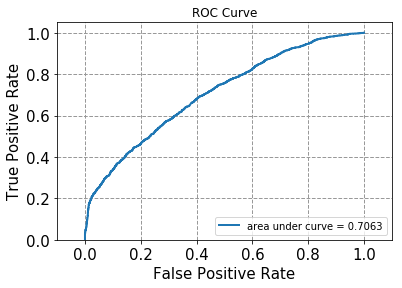

Confusion Matrix without Normalization
[[1220 1191]
 [ 772 2353]]
Normalized Confusion Matrix
[[0.51 0.49]
 [0.25 0.75]]


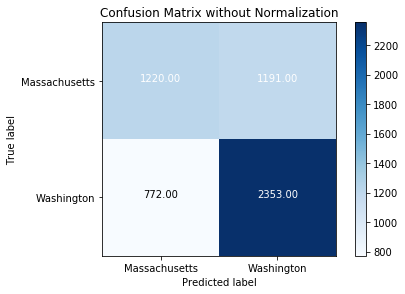

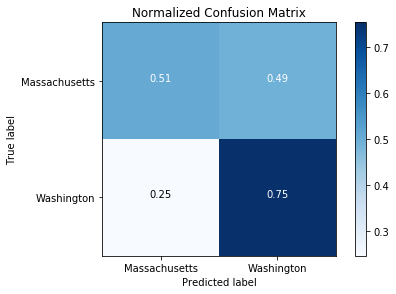

Accuracy: 0.6454118497109826
Recall: 0.75296
Precision: 0.6639390519187359


In [9]:
plot_roc(fpr, tpr)
compute_and_plot_confusion_matrix(y_test, test_predict)

accuracy = accuracy_score(y_test, test_predict)
print('Accuracy:',accuracy)

recall = recall_score(y_test, test_predict)
print('Recall:',recall)

precision = precision_score(y_test, test_predict)
print('Precision:',precision)

## MultinomialNB

In [28]:
X=texts
y=locations

X = vectorizer.fit_transform(X)
X = tfidf_transformer.fit_transform(X)
X = nmf.fit_transform(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

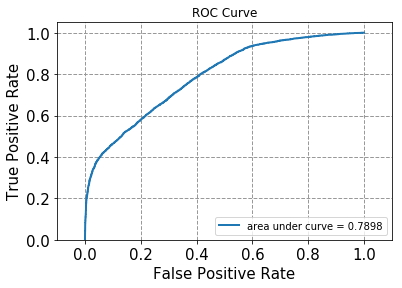

Confusion Matrix without Normalization
[[ 385 5613]
 [  33 7808]]
Normalized Confusion Matrix
[[0.06 0.94]
 [0.   1.  ]]


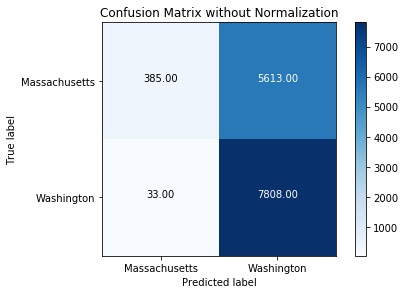

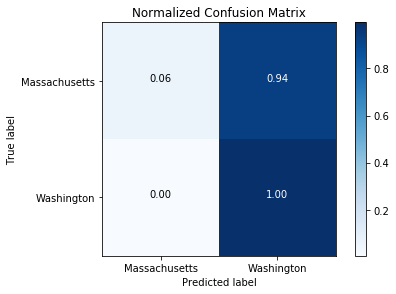

Accuracy: 0.5920225449815738
Recall: 0.9957913531437317
Precision: 0.5817748304895314


In [29]:
clf = MultinomialNB().fit(X_train, y_train)

test_score = clf.predict_proba(X_test)
test_predict = clf.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, test_score[:,1])

plot_roc(fpr, tpr)
compute_and_plot_confusion_matrix(y_test, test_predict)

accuracy = accuracy_score(y_test, test_predict)
print('Accuracy:',accuracy)

recall = recall_score(y_test, test_predict)
print('Recall:',recall)

precision = precision_score(y_test, test_predict)
print('Precision:',precision)

## GaussianNB

In [24]:
X=texts
y=locations

X = vectorizer.fit_transform(X)
X = tfidf_transformer.fit_transform(X)
X = svd.fit_transform(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


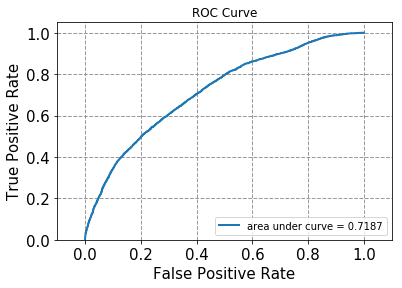

Confusion Matrix without Normalization
[[2969 3029]
 [1568 6273]]
Normalized Confusion Matrix
[[0.49 0.51]
 [0.2  0.8 ]]


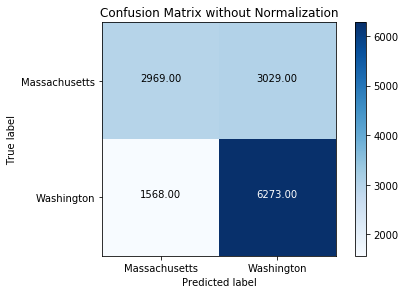

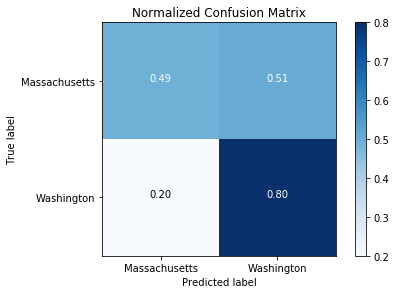

Accuracy: 0.6678228195678878
Recall: 0.800025506950644
Precision: 0.6743711029886046


In [25]:

clf3 = GaussianNB().fit(X_train, y_train)

test_score = clf3.predict_proba(X_test)
test_predict = clf3.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, test_score[:,1])

plot_roc(fpr, tpr)
compute_and_plot_confusion_matrix(y_test, test_predict)

accuracy = accuracy_score(y_test, test_predict)
print('Accuracy:',accuracy)

recall = recall_score(y_test, test_predict)
print('Recall:',recall)

precision = precision_score(y_test, test_predict)
print('Precision:',precision)

## Logistic Regression

In [34]:
X=texts
y=locations

X = vectorizer.fit_transform(X)
X = tfidf_transformer.fit_transform(X)
X = svd.fit_transform(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

C:\Users\nobod\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


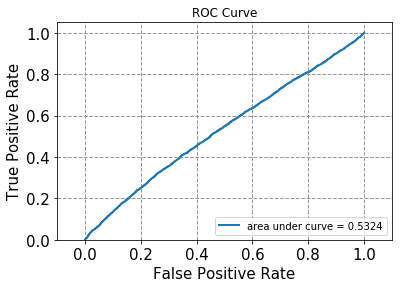

Confusion Matrix without Normalization
[[ 739 5259]
 [ 971 6870]]
Normalized Confusion Matrix
[[0.12 0.88]
 [0.12 0.88]]


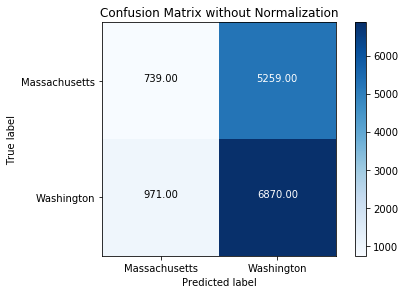

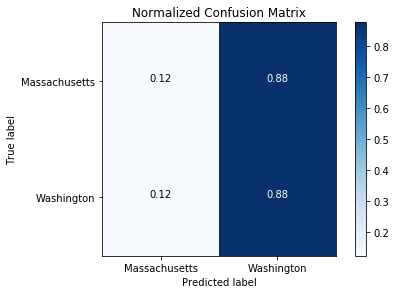

Accuracy: 0.5498229640870005
Recall: 0.8761637546231348
Precision: 0.5664110808805343


In [35]:
logistic = LogisticRegression(penalty='l2', C = 0.001)
logistic.fit(X_train, y_train)

test_score = clf3.predict_proba(X_test)
test_predict = clf3.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, test_score[:,1])

plot_roc(fpr, tpr)
compute_and_plot_confusion_matrix(y_test, test_predict)

accuracy = accuracy_score(y_test, test_predict)
print('Accuracy:',accuracy)

recall = recall_score(y_test, test_predict)
print('Recall:',recall)

precision = precision_score(y_test, test_predict)
print('Precision:',precision)